# Second try

## add null folder

In [1]:
from fastai.vision.all import *
from fastbook import *

In [6]:
# naming the folders and location where the files will be downloaded #
hair_types = 'cornrows men black', 'bald men black', 'fade men black'
path = Path("hair")

In [7]:
(path).ls()

FileNotFoundError: [Errno 2] No such file or directory: 'hair'

In [8]:
# Creating directories for images and downloading them #
if not path.exists():
    path.mkdir()
    for o in hair_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg( f'{o} hair', max_images=100)
        download_images(dest, urls=results)

In [9]:
(path).ls()

(#3) [Path('hair/cornrows men black'),Path('hair/bald men black'),Path('hair/fade men black')]

In [10]:
# making null class #
dest = (path/"not hair")
dest.mkdir()

In [11]:
(path).ls()

(#4) [Path('hair/cornrows men black'),Path('hair/not hair'),Path('hair/bald men black'),Path('hair/fade men black')]

In [12]:
# collecting images from the image path #
fns = get_image_files(path)
fns

(#295) [Path('hair/cornrows men black/00000047.jpg'),Path('hair/cornrows men black/00000055.jpg'),Path('hair/cornrows men black/00000036.jpg'),Path('hair/cornrows men black/00000030.jpg'),Path('hair/cornrows men black/00000097.jpg'),Path('hair/cornrows men black/00000029.jpg'),Path('hair/cornrows men black/00000091.jpg'),Path('hair/cornrows men black/00000093.jpg'),Path('hair/cornrows men black/00000090.jpg'),Path('hair/cornrows men black/00000035.jpg')...]

In [13]:
# check for damaged images # 
failed = verify_images(fns)
failed

(#0) []

In [14]:
# # Delete damaged images #
# failed.map(Path.unlink);

**Datablock**

In [15]:
# custom function to get labels as a list of strings #
def parent_label_multi(o):
    return [Path(o).parent.name]

In [16]:
dblock = DataBlock(
    # blocks=(ImageBlock, MultiCategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label_multi
    )

dsets = dblock.datasets(path)
dsets.train[0]

(Path('hair/bald men black/00000048.jpg'), ['bald men black'])

In [19]:
MultiCategoryBlock??

Signature: MultiCategoryBlock(encoded=False, vocab=None, add_na=False)
Source:   
def MultiCategoryBlock(encoded=False, vocab=None, add_na=False):
    "`TransformBlock` for multi-label categorical targets"
    tfm = EncodedMultiCategorize(vocab=vocab) if encoded else [MultiCategorize(vocab=vocab, add_na=add_na), OneHotEncode]
    return TransformBlock(type_tfms=tfm)
File:      /opt/conda/lib/python3.7/site-packages/fastai/data/block.py
Type:      function


In [20]:
doc(MultiCategoryBlock)

MultiCategoryBlock [source] MultiCategoryBlock ( encoded = False , vocab = None , add_na = False ) 
 
 TransformBlock for multi-label categorical targets 
 Show in docs

In [21]:
# dblock with transformation blocks added and Add #na# to vocab #
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(add_na=True)), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label_multi
    )

dsets = dblock.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=817x1222, TensorMultiCategory([0., 1., 0., 0.]))

In [22]:
dsets.vocab

['#na#', 'bald men black', 'cornrows men black', 'fade men black']

In [23]:
# view shapes of input and targets #
x,y = dsets.train[0]
x.shape, y.shape

((1222, 817), torch.Size([4]))

In [24]:
#  indices where our condition is true #
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['bald men black']

**dataloaders**

**NB. Presizing**
```python
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75)
```

In [27]:
# creating dataloaders with presizing #
hair = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(add_na=True)), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label_multi,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
    )

dls = hair.dataloaders(path)

In [28]:
dls.vocab

['#na#', 'bald men black', 'cornrows men black', 'fade men black']

In [29]:
# view shape of one batch of data #
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 4]))

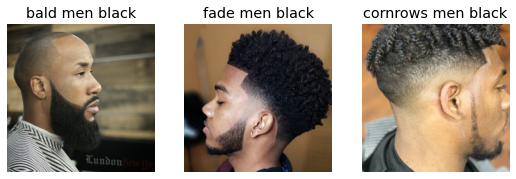

In [30]:
# view training batch sample #
dls.train.show_batch(nrows=1, ncols=3)

In [31]:
# create learner #
learn = cnn_learner(dls, resnet18)

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [32]:
# one batch of activations shape #
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape, y.shape

(torch.Size([64, 4]), torch.Size([64, 4]))

In [33]:
# init activations #
activs[0]

TensorBase([-0.6864, -2.4145,  4.2485, -0.7450], grad_fn=<AliasBackward0>)

In [34]:
# fit model with threshold = 0.8 #
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.8))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.105541,1.144782,0.550847,00:08
1,1.016743,0.728759,0.733051,00:09
2,0.890434,0.570300,0.855932,00:08
3,0.791725,0.518770,0.872881,00:08


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.452882,0.519187,0.881356,00:09
1,0.429765,0.479295,0.877119,00:08
2,0.419488,0.458354,0.902542,00:08


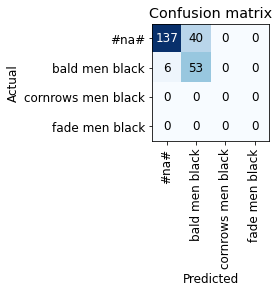

In [35]:
# Confussion matrix #
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

,target,predicted,probabilities,loss
0,cornrows men black,#na#;fade men black,"TensorBase([0.7948, 0.0277, 0.0013, 0.9999])",4.332963466644287
1,fade men black,bald men black,"TensorBase([0.4737, 0.9932, 0.0049, 0.1704])",1.8505431413650513
2,fade men black,#na#;bald men black;fade men black,"TensorBase([0.5589, 0.9971, 0.0025, 0.5304])",1.8286548852920532
3,bald men black,fade men black,"TensorBase([0.3776, 0.3766, 0.0011, 0.9210])",0.9975831508636475
4,fade men black,#na#;bald men black,"TensorBase([0.6303, 0.7818, 0.0064, 0.3254])",0.9116091728210449


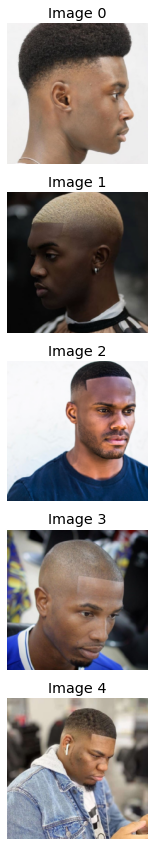

In [36]:
# show top losses #
interp.plot_top_losses(5, nrows=5)

**make preddictions**

In [42]:
path

Path('hair')

In [44]:
path = Path("test_images")

In [45]:
(path).ls()

(#6) [Path('test_images/b7da3bb0597cdf5add5cbef739152391.jpg'),Path('test_images/leon-thomas-iii-hairstyle-0.jpg'),Path('test_images/73b98f7f2e590ee9a1406cb1bf574382-470x834.jpg'),Path('test_images/b533a6faadcd88d1d760de283587bb37.jpg'),Path('test_images/boer-goat-2273921_1920.jpg'),Path('test_images/Red-Sport-Car.jpg')]

In [46]:
path/"73b98f7f2e590ee9a1406cb1bf574382-470x834.jpg"

Path('test_images/73b98f7f2e590ee9a1406cb1bf574382-470x834.jpg')

In [47]:
# test image paths #
im1 = path/"73b98f7f2e590ee9a1406cb1bf574382-470x834.jpg"
im2 = path/"b533a6faadcd88d1d760de283587bb37.jpg"
im3 = path/"b7da3bb0597cdf5add5cbef739152391.jpg"
goat = path/"boer-goat-2273921_1920.jpg"
leo_t = path/"leon-thomas-iii-hairstyle-0.jpg"
car = path/"Red-Sport-Car.jpg"

In [48]:
learn.predict(leo_t)

((#3) ['#na#','bald men black','fade men black'],
 TensorBase([ True,  True, False,  True]),
 TensorBase([0.6378, 0.8439, 0.0029, 0.7506]))